##Data set downloading

In [ ]:
! pip install -q kaggle

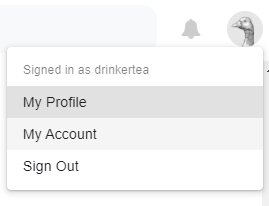  
-> My Account -> Create API token  
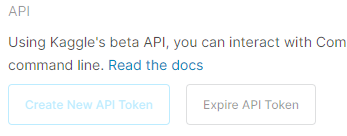

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"drinkertea","key":"b42eeeae6cbf857bd3e2581780cb14c5"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d christianlillelund/csgo-round-winner-classification

  0% 0.00/3.53M [00:00<?, ?B/s]
100% 3.53M/3.53M [00:00<00:00, 57.3MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip csgo-round-winner-classification.zip -d train

Archive:  csgo-round-winner-classification.zip
  inflating: train/csgo_round_snapshots.csv  


##Постановка задачи

Собраны данные из множества онлайн-матчей CS:GO, игры, где сражаются две команды по пять человек: террористы, цель которых установить и подорвать бомбу по истечению 45 секунд, либо уничтожить весь спецназ; спецназ, цель которого уничтожить террористов либо обезвредить установленную бомбу.  
Каждый раунд, с некоторым интервалом времени делался "снимок" игры, а именно - количество здоровья команды, количество брони, наличие оружия, факт устрановки бомбы и текущий счет.

Задача состоит в определении победителя раунда по данным показателям.

##Чтение данных

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# Comment this line if you use light color scheme
plt.style.use('dark_background')

Чтение данных

In [ ]:
data_raw = pd.read_csv('train/csgo_round_snapshots.csv')

In [ ]:
data_raw.shape

(122410, 97)

In [ ]:
data_raw.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


Первый взягляд на сырые данные.

Можно заметить "непопулярные столбцы" с оружием/гранатами.  
Увидеть максимальную длительность раунда - 175 секунд.  
Потенциальные выбросы - когда количество здоровья превышает 500 (5 игроков * 100).  


In [ ]:
data_raw.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,...,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.0,122410.000000,122410.0,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,2.773638,1.613724,4.273752,4.266187,0.274602,1.243926,0.134613,0.007638,0.573695,0.321191,0.0,0.000082,0.151989,0.106053,0.004011,0.001773,0.110138,0.004738,0.0,0.000792,0.011045,0.110301,0.006919,3.310195,0.000008,0.0,0.063818,0.002729,1.076236,0.052733,...,0.000163,0.000155,0.0,0.000057,0.0,0.000139,0.000719,0.000008,0.239147,0.824941,0.059505,0.020440,0.046426,0.036468,0.007557,0.000261,0.440675,0.380868,0.061751,0.009386,3.179789,0.122400,0.236974,0.291618,0.174046,0.004934,0.008120,0.028323,0.899101,0.438257,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,2.010915,1.605780,1.205500,1.228325,0.584092,1.363887,0.460303,0.091456,0.673249,0.476667,0.0,0.009038,0.445910,0.379993,0.063206,0.042067,0.388980,0.070780,0.0,0.037148,0.112130,0.405933,0.086935,1.625785,0.002858,0.0,0.262884,0.053096,1.219112,0.247009,...,0.012781,0.012458,0.0,0.007562,0.0,0.011784,0.026803,0.002858,0.554073,1.139545,0.264790,0.146044,0.230066,0.211221,0.088096,0.016166,0.834516,0.814730,0.288498,0.100087,1.586788,0.438928,0.533787,0.579258,0.425142,0.074807,0.094879,0.191538,1.281569,0.808149,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

Проверка на наличие пропущенных значений - отсутсвтвуют.

In [ ]:
data_raw.isna().any().any()

False

##Анализ вооружения

Посмотрим на популярность различных орижий и гранат у сторон.

In [ ]:
tools = data_raw.filter(regex='weapon|grenade',axis=1)
total_tools = tools.sum()
total_tools = total_tools.sort_values()

t_total_tools = total_tools.filter(regex='^t_')
ct_total_tools = total_tools.filter(regex='^ct_')

total_tools_readable = total_tools.loc[total_tools > 1000]
t_total_tools_readable = t_total_tools.loc[t_total_tools > 1000]
ct_total_tools_readable = ct_total_tools.loc[ct_total_tools > 1000]
print(total_tools.shape, total_tools_readable.shape)
print("t", t_total_tools.shape, t_total_tools_readable.shape)
print("ct", ct_total_tools.shape, ct_total_tools_readable.shape)

(80,) (44,)
t (40,) (21,)
ct (40,) (23,)


Наиболее популярные пукупки "террористов"

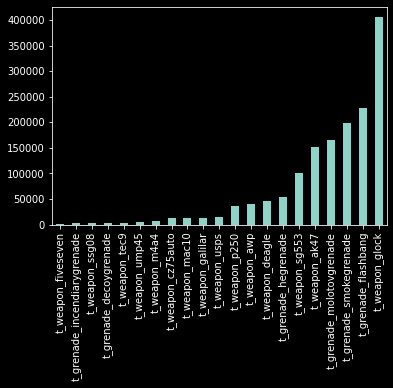

In [ ]:
t_total_tools_readable.plot(kind='bar', stacked=True)

Наиболее популярные пукупки "спецназа"

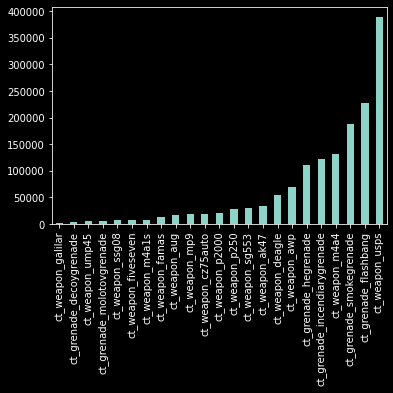

In [ ]:
ct_total_tools_readable.plot(kind='bar', stacked=True)

Наиболее популярны стандартные пистолеты (которые не нужно покупать), они слабые и есть всегда, скорее всего будут иметь слабую корреляцию с исходом раунда.  
Также из 80ти инструментов, наиболее часто покупались (более 1000 раз за все 120к замеров) лишь 44, откинув непопулярные можно получить читабельный график. Такие оружия мало влияют на исход, но в тоже время откинув эти признаки мы скорее всего получим только ускорение, а не улучшение результата.

##Откидывание столбцов

На основе анализа откинем непопулярные столбцы с покупками для упрощения дальнейшего анализа, в выборке для обучения их можно оставить.

Сохраним столбцы не о покупках

In [ ]:
non_tools = data_raw.filter(regex='^((?!weapon|grenade).)*$',axis=1)
non_tools.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,CT


Оставим только столбцы с покупками и удалим непопулярные

In [ ]:
data_num = data_raw.drop(non_tools, axis=1)
data_num.head()

,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_num.quantile(0.95)

ct_weapon_ak47                 2.0
t_weapon_ak47                  4.0
ct_weapon_aug                  1.0
t_weapon_aug                   0.0
ct_weapon_awp                  2.0
                              ... 
t_grenade_incendiarygrenade    0.0
ct_grenade_molotovgrenade      0.0
t_grenade_molotovgrenade       5.0
ct_grenade_decoygrenade        0.0
t_grenade_decoygrenade         0.0
Name: 0.95, Length: 80, dtype: float64

In [ ]:
popular_mask = data_num.quantile(0.95) > 0
popular_mask.values

array([ True,  True,  True, False,  True,  True, False, False,  True,
        True, False, False,  True, False, False, False, False,  True,
       False,  True, False, False,  True, False,  True, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True, False, False])

In [ ]:
data_pop = data_num.loc[:, popular_mask.values]
data_pop.head()

,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


вернем столбцы

In [ ]:
data_pop = pd.concat([non_tools, data_pop], axis=1)
data_pop.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,round_winner,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Columns drop result

In [ ]:
data_pop.shape

(122410, 50)

Осталось 50 признаков, теперь их будет проще визуализировать

In [ ]:
data = data_pop

## Матрица корреляции

Заменим классовый исход на число (1 или 0), чтобы посмотреть корреляцию

In [ ]:
winner_dummies = pd.get_dummies(data['round_winner'])
data_no_class_res = pd.concat((winner_dummies, data), axis=1)
data_no_class_res = data_no_class_res.drop(['round_winner'], axis=1)
data_no_class_res.head()

,CT,T,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
0,1,0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,1,0,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,1,0,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


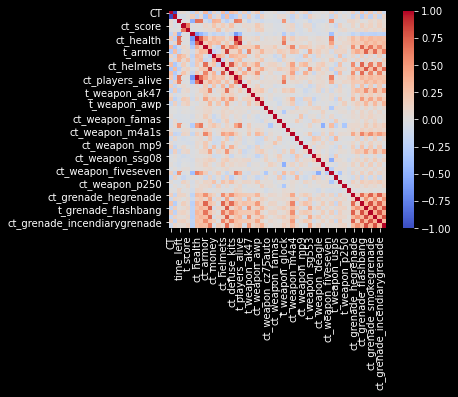

In [ ]:
corr_mat = data_no_class_res.corr()
#corr_mat#[['CT', 'T']]

sns.heatmap(corr_mat, square=True, cmap='coolwarm')


Матрица получилась очень болльшой, попробуем разбить по командам

In [ ]:
ct_data = data_no_class_res.filter(regex='^ct_',axis=1)
t_data = data_no_class_res.filter(regex='^t_',axis=1)

t_data_to_corr = data_no_class_res.drop(ct_data, axis=1)
t_data_to_corr = t_data_to_corr.drop(['CT'], axis=1)
ct_data_to_corr = data_no_class_res.drop(t_data, axis=1)
ct_data_to_corr = ct_data_to_corr.drop(['T'], axis=1)

t_corr_mat = t_data_to_corr.corr()
ct_corr_mat = ct_data_to_corr.corr()


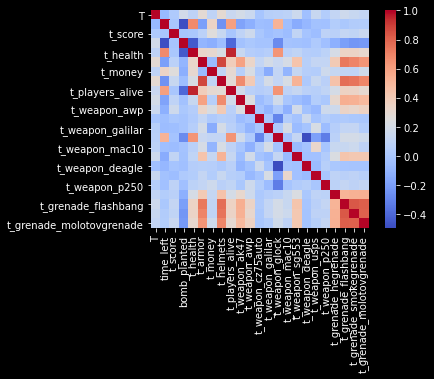

In [ ]:
sns.heatmap(t_corr_mat, square=True, cmap='coolwarm')

In [ ]:
t_corr_mat['t_armor']

T                           0.290753
time_left                  -0.195579
t_score                     0.081671
bomb_planted               -0.096619
t_health                    0.325604
t_armor                     1.000000
t_money                    -0.064501
t_helmets                   0.877626
t_players_alive             0.384980
t_weapon_ak47               0.591156
t_weapon_awp                0.331122
t_weapon_cz75auto           0.113717
t_weapon_galilar            0.196697
t_weapon_glock              0.146132
t_weapon_mac10              0.209005
t_weapon_sg553              0.444442
t_weapon_deagle             0.062224
t_weapon_usps               0.118831
t_weapon_p250               0.117875
t_grenade_hegrenade         0.406992
t_grenade_flashbang         0.739180
t_grenade_smokegrenade      0.700143
t_grenade_molotovgrenade    0.639853
Name: t_armor, dtype: float64

Так немного лучше, но все еще много столбцов и на карте температур пропускаются четные значения, но общая картина видна, и отобрав отдельные столбцы можно точно убедитсья в корреляции тех или иных признаков.  
К примеру виднро, что закупка гранат сильно коррелирует между собой, а так же с покупкой брони и хорошего оружия (ak47 или awp).  
Это можно обосновать тем, что как правило игроки закупаются либо "полным комплектом", либо проводят раунды без покупок, чтобы накопить деньги.

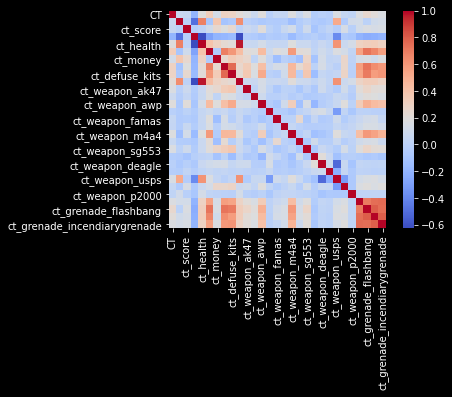

In [ ]:
sns.heatmap(ct_corr_mat, square=True, cmap='coolwarm')

##Анализ и визуализация

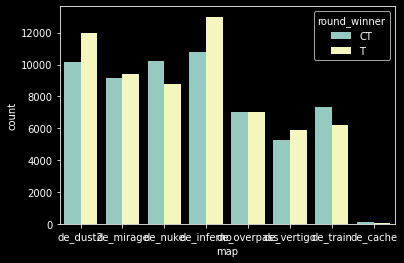

In [ ]:
sns.countplot(x="map", hue="round_winner", data=data)

На данном графике видно какие карты наиболее сбалансированы, а так же то, что по карте `de_cache` значительно меньше данных.

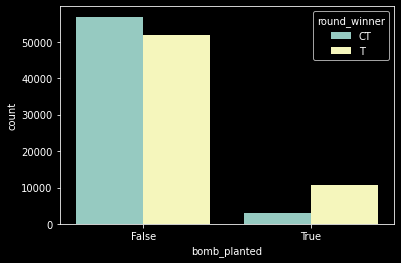

In [ ]:
sns.countplot(x="bomb_planted", hue="round_winner", data=data)

А тут видна связь победы "террористов" и установки бомбы.

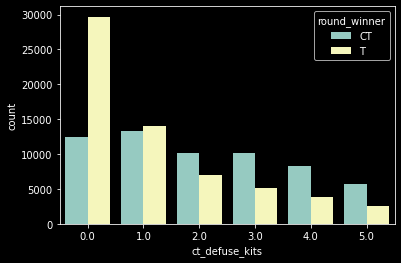

In [ ]:
sns.countplot(x="ct_defuse_kits", hue="round_winner", data=data)

Аналогично, наличие наборов для разминирования коррелирует с победой "спецназа", такой сильный выброс при его полном отсутствии скорее всего обусловлен "экономическими" раундами, когда у "спецназа" нет денег, а у "террористов" их значительно больше и они превосходят противника по боевой мощи.

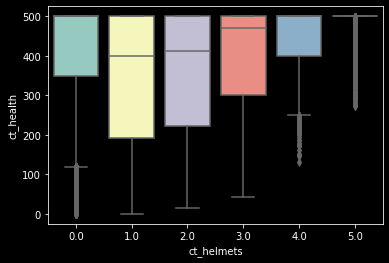

In [ ]:
sns.boxplot(x='ct_helmets', y = 'ct_health', data = data)

Тут можно увидеть, что с чем больше игроков в шлемах, тем реже они умирают. Исключение составляет полное отсутствие шлемов, видимо такой результат получается из тех же "экономических" раундов и первых "пистолетных".

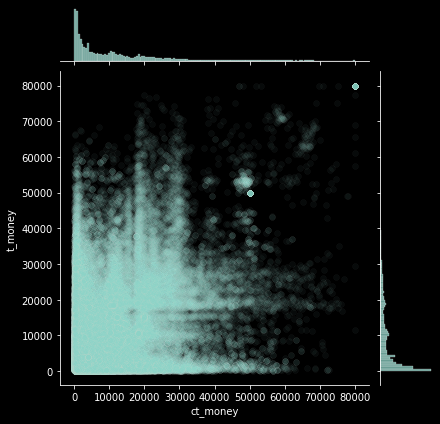

In [ ]:
sns.jointplot(x='ct_money', y='t_money', alpha=.05, data=data)

А здесь видны выбросы по деньгам, когда обе комнды имеют максимальное их количество, скорее всего это дополнительные раунды, когда ничья невозможна и играют до победы, в этом случае каждой команде дают максимальное колличество денег.  
В тоже время корреляция их колличества с результатом матча невелика. Это обусловлено тем, что замеры по деньгам делались не на начало раунда (до покупок), а в моментах, когда большая их часть уже была потрачена.

In [ ]:
t_corr_mat['t_money']['T']

0.0983618940681755

##Борьба с выбросами

In [ ]:
((data['t_money'] > 40000) & (data["t_money"] == data["ct_money"])).value_counts()

False    122203
True        207
dtype: int64

In [ ]:
(data["ct_health"] > 500).value_counts()

False    122410
Name: ct_health, dtype: int64

In [ ]:
data_fix = data.loc[(data["ct_health"] <= 500).values]
data_fix.shape

(122410, 50)

In [ ]:
data_fix = data_fix.loc[((data_fix['t_money'] < 40000) | (data_fix["t_money"] != data_fix["ct_money"])).values]
data_fix.shape

(122203, 50)

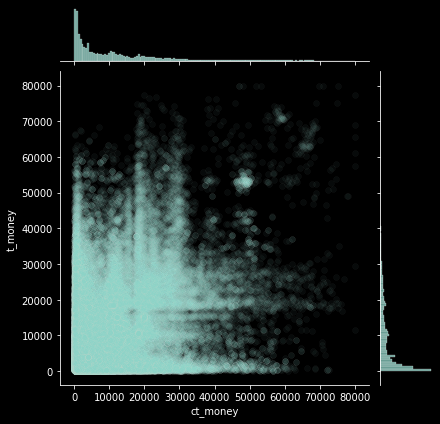

In [ ]:
sns.jointplot(x='ct_money', y='t_money', alpha=.05, data=data_fix)

##Обработка категориальных признаков

In [ ]:
data.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,round_winner,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
map_dummies = pd.get_dummies(data['map'])

data = pd.concat((map_dummies, data), axis=1)
data = data.drop(['map'], axis=1)

map_dummies.head()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0


Произвели замену категориальных и булевых признаков на числовые

In [ ]:
data["bomb_planted"] = data["bomb_planted"].astype(int)
data.head()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,round_winner,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
0,0,1,0,0,0,0,0,0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,0,0,0,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0,1,0,0,0,0,0,0,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0,1,0,0,0,0,0,0,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.to_csv('drive/MyDrive/csgo_data_processed_unnorm.csv')

## Нормализация количественных признаков

"отщипнем" стобец с результатами

In [ ]:
Y = data['round_winner']
data = data.drop(['round_winner'], axis=1)

нормализуем

In [ ]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)
data_stand.describe()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
count,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05
mean,-3.478761e-14,-1.809152e-15,5.695622e-14,9.259445e-15,-1.100441e-13,8.469627e-14,4.304846e-17,-7.750451e-15,-3.982956e-13,2.963790e-15,1.196875e-16,8.486572e-16,-1.097754e-15,-7.064677e-16,1.334322e-15,1.457048e-15,-1.181652e-15,-6.050321e-16,-3.990456e-15,6.669069e-15,2.471431e-15,-4.284551e-16,-1.244370e-14,-2.018571e-14,1.421405e-14,-1.927248e-14,-1.474041e-14,1.053678e-14,2.331931e-14,5.770488e-14,-8.834825e-15,3.832387e-16,-7.556439e-15,4.078579e-14,-9.069489e-16,2.888523e-14,-6.099633e-16,-8.974913e-14,-2.942655e-14,1.020922e-14,-1.009923e-15,6.639734e-16,-2.270325e-16,-1.603622e-15,-6.888222e-15,5.320283e-15,7.176840e-15,-2.292477e-15,-6.540272e-15,2.054035e-15,-2.120041e-15,-1.099923e-15,5.252760e-15,-5.240086e-15,2.136497e-15,2.924266e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.443746e-02,-4.699476e-01,-4.914177e-01,-4.229651e-01,-4.289748e-01,-3.605310e-01,-3.519399e-01,-3.163643e-01,-1.797053e+00,-1.400570e+00,-1.405696e+00,-3.547628e-01,-3.115098e+00,-2.878197e+00,-1.836769e+00,-1.709535e+00,-8.728477e-01,-9.242140e-01,-1.115359e+00,-1.379292e+00,-1.004947e+00,-3.545210e+00,-3.473175e+00,-4.701341e-01,-9.120451e-01,-2.924449e-01,-8.521283e-01,-6.738269e-01,-3.408521e-01,-2.790931e-01,-2.831460e-01,-2.717236e-01,-2.036060e+00,-2.427621e-01,-8.828025e-01,-2.606018e-01,-3.112070e-01,-4.316165e-01,-7.239215e-01,-2.247249e-01,-5.280604e-01,-4.674772e-01,-2.140449e-01,-2.003915e+00,-2.788613e-01,-4.439486e-01,-5.034342e-01,-4.093834e-01,-7.015631e-01,-5.422971e-01,-1.045333e+00,-1.035457e+00,-8.866441e-01,-8.895655e-01,-6.871819e-01,-8.129257e-01
25%,-3.443746e-02,-4.699476e-01,-4.914177e-01,-4.229651e-01,-4.289748e-01,-3.605310e-01,-3.519399e-01,-3.163643e-01,-7.888871e-01,-7.743129e-01,-7.837464e-01,-3.547628e-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_stand.to_csv('drive/MyDrive/csgo_data_processed.csv')

## Разбиение данных

In [ ]:
from sklearn.model_selection import train_test_split

X = data_stand
y = Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(91807, 30603)

## Метод ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
y_test_predict = neigh.predict(X_test)

In [ ]:
y_train_predict = neigh.predict(X_train)

Предсказание результата занимает довольно большое время, в качестве оптимизации можно было избавиться от большего колличества малозначимых, слабокоррелируемых с результатом признаков.

Либо объединить некоторые из них.  
К примеру t_health & ct_health -> t_health / ct_health (money|armor|helmets)  
Или t_grenade*& -> t_grenades_total

Но в таком случае точность предсказаний бы упала

In [ ]:
test_pass_rate = (y_test_predict == y_test).sum() / len(y_test_predict)
test_pass_rate

0.8637061725974577

In [ ]:
train_pass_rate = (y_train_predict == y_train).sum() / len(y_train_predict)
train_pass_rate

0.9448516997614561

Таким образом ошибка на тестовой выборке

In [ ]:
1 - test_pass_rate

0.13629382740254226

А ошибка на тренировочной

In [ ]:
1 - train_pass_rate

0.05514830023854389

Разница между ошибками не большая и тестовая ошибка весьма приемлема, можно считать, что число соседей выбрано хорошо.   
В тоже время результат может быть улучшен если еще поработать с данными, например посмотреть на выбросы и попытаться побороть их, поиграться с количеством соседей.   
Главным препятствием для экспериментов является долгое время работы алгоритма. В таком случае можно сперва протестировать методы на меньшем количестве данных.

##PCA


In [ ]:
pca = PCA(n_components = 2)
pca.fit(X)
X_pca = pca.transform(X)
print(X.shape)
print(X_pca.shape)
print(pca.explained_variance_ratio_)

(122410, 56)
(122410, 2)
[0.15425041 0.08357815]


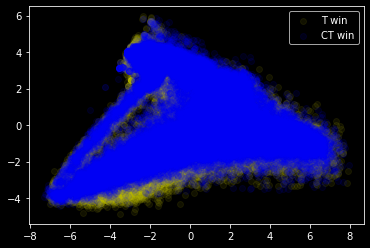

In [ ]:
plt.scatter(X_pca[y == "T", 0], X_pca[y == "T", 1], color = 'y', alpha = 0.09, label = 'T win')
plt.scatter(X_pca[y == "CT", 0], X_pca[y == "CT", 1], color = 'b', alpha = 0.09, label = 'CT win')
plt.legend()

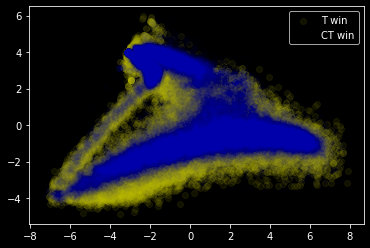

In [ ]:
plt.scatter(X_pca[y == "T", 0], X_pca[y == "T", 1], color = 'y', alpha = 0.09, label = 'T win')
plt.scatter(X_pca[y == "CT", 0], X_pca[y == "CT", 1], color = 'b', alpha = 0.01, label = 'CT win')
plt.legend()

После понижения размерности до двух, результаты практически наложились друг на друга, что говорит о слишком сильном уменеьшении и плохом результате обучения в следствии.

### KNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27)

pca = PCA(n_components = 2)
pca.fit(X_train, y_train)
X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_test_predict = neigh.predict(X_test)
y_train_predict = neigh.predict(X_train)

print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_train, y_train_predict))

0.593209816031108
0.7860620649841515


Точность упала почти до монетки, как и было видно на графике, но скороть обучения сильно возросла, теперь пожно поиграться с разным числом соседей


In [ ]:
neighbors = [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]
accuracies_test = []
accuracies_train = []
for k in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_predict_test = neigh.predict(X_test)
    y_predict_train = neigh.predict(X_train)
    accuracies_test.append(accuracy_score(y_test, y_predict_test))
    accuracies_train.append(accuracy_score(y_train, y_predict_train))
print(accuracies_test)

[0.5694212985655002, 0.593209816031108, 0.5984053850929647, 0.5962814103192497, 0.6011502140313041, 0.604254484854426, 0.6062804300232003, 0.6105610561056105, 0.611051204130314, 0.6135346207888116, 0.6119661471097605, 0.6132405319739895, 0.6126523543443453, 0.6110185275953338]


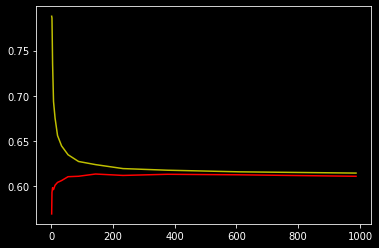

In [ ]:
plt.plot(neighbors, accuracies_test, 'r')
plt.plot(neighbors, accuracies_train, 'y')
pass

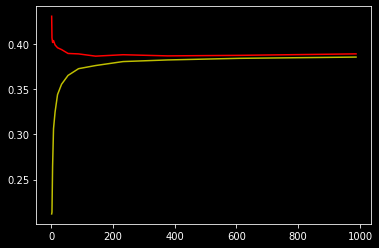

In [ ]:
test_error = [1 - x for x in accuracies_test]
train_error = [1 - x for x in accuracies_train]
plt.plot(neighbors, test_error, 'r')
plt.plot(neighbors, train_error, 'y')
pass

### SVM analisys

In [ ]:
svm_model = SVC().fit(X_train, y_train)

regression_y = svm_model.predict(X_test)
print(accuracy_score(y_test, regression_y))

0.6069666372577852


SVM тоже не помог, попробуем найти оптимально число признаков

In [ ]:
_, d = X.shape
pca = PCA(n_components = d)
pca.fit(X)
X_proj = pca.transform(X)

Text(0, 0.5, 'Explained variance ratio')

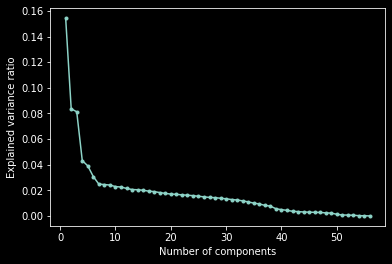

In [ ]:
plt.plot(np.arange(1, d + 1), pca.explained_variance_ratio_, '.-')
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')

Судя по графику имеет смысл оставить около семи признаков, но давайте убедимся в этом на практике, обучим модели и сравним ошибки

#### Долго и некрасиво

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27)
print('n components', 'train error', 'test error')
for n_comp in [2, 10, 20, 30, 40, d]:
    pca = PCA(n_components = n_comp)
    pca.fit(X_train, y_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca  = pca.transform(X_test)
    svc = SVC(kernel = 'linear')
    svc.fit(X_train_pca, y_train)   
    y_train_pred = svc.predict(X_train_pca)
    y_test_pred  = svc.predict(X_test_pca)
    print(n_comp, accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

n components train error test error
2 0.5464180291263193 0.5428879521615528
10 0.7225483895563519 0.7242427213018332
20 0.7363055104730576 0.73512400745025
30 0.7470672170967355 0.7451230271542005
40 0.7516747089001928 0.7496323889814724
56 0.7523391462524645 0.751560304545306


2 0.5464180291263193 0.5428879521615528  
10 0.7225483895563519 0.7242427213018332  
20 0.7363055104730576 0.73512400745025  
30 0.7470672170967355 0.7451230271542005  
40 0.7516747089001928 0.7496323889814724  
56 0.7523391462524645 0.751560304545306  

In [ ]:
def trainSVM(num_comp):
    pca = PCA(n_components = num_comp)
    pca.fit(X_train, y_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca  = pca.transform(X_test)
    svc = SVC(kernel = 'linear')
    svc.fit(X_train_pca, y_train)   
    y_train_pred = svc.predict(X_train_pca)
    y_test_pred  = svc.predict(X_test_pca)
    return y_test_pred, y_train_pred

for n_comp in [3, 4, 5, 7, 8]:
    y_test_pred, y_train_pred = trainSVM(n_comp)
    print(n_comp, accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))


3 0.7154247497467513 0.7172499428160638
4 0.7190954938076617 0.7197660360095416
5 0.719411373860381 0.7199620952194229
7 0.7196836842506563 0.7207463320589484
8 0.7201956277843737 0.7202235074992648


####Результаты

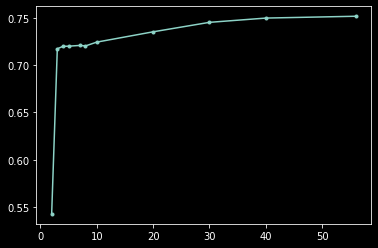

In [ ]:
n_comps = [2, 3, 4, 5, 7, 8, 10, 20, 30, 40, d]
accyeracies_svc = [
    0.5428879521615528,
    0.7172499428160638,
    0.7197660360095416,
    0.7199620952194229,
    0.7207463320589484,
    0.7202235074992648,
    0.7242427213018332,
    0.73512400745025,
    0.7451230271542005,
    0.7496323889814724,
    0.751560304545306,
]
plt.plot(n_comps, accyeracies_svc, '.-')

Для линейного SVC происходит скачок точности между 2 и 3 разерностями, после чего рост сильно замедляется, но эти результаты были получены для конкретного классификатора, я все же остановлюсь на семи компонентах и опробую разные классификаторы. благо теперь скорость обучения будет намного быстрее.

###PCA 7 components

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27)
pca3 = PCA(n_components = 7)
pca3.fit(X_train, y_train)
X_train_pca = pca3.transform(X_train)
X_test_pca  = pca3.transform(X_test)

In [ ]:
print(X_train.shape)
print(X_train_pca.shape)

(91807, 56)
(91807, 7)


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=144)
neigh.fit(X_train_pca, y_train)

y_test_predict = neigh.predict(X_test_pca)
y_train_predict = neigh.predict(X_train_pca)

print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_train, y_train_predict))

0.7410711368166519
0.7485812628666659


In [ ]:
model = RandomForestClassifier(n_estimators=2048)
model.fit(X_train_pca, y_train)

y_test_predict = model.predict(X_test_pca)
y_train_predict = model.predict(X_train_pca)

print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_train, y_train_predict))

0.8006731366205928
0.9971026174474713


In [ ]:
model = SVC()
model.fit(X_train_pca, y_train)

y_test_predict = model.predict(X_test_pca)
y_train_predict = model.predict(X_train_pca)

print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_train, y_train_predict))

0.7356795085449139
0.7416427941224525


In [ ]:
model = OneVsRestClassifier(LinearSVC(), n_jobs=8)
model.fit(X_train_pca, y_train)

y_test_predict = model.predict(X_test_pca)
y_train_predict = model.predict(X_train_pca)

print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_train, y_train_predict))

0.7197987125445218
0.7181042839870598


Точности KNN по всем признакам достичь так и не удалось, но учитывая возросшую скорость считаю результаты неплохими

### Вывод

В данном случае PCA не помог снизить ошибку, но позволил ускорить предсказание исхода, что на практике даже полезнее, поскольку данные будут известны не раньше чем за две менуты до исхода раунда.

Так же стоит иметь ввиду что РСА ничего не знает о физическом смысле данных, скорее всего, если попытаться сперва свернуть их вручную, можно добиться более хороших результатов.